### Week 7 Lab Exercise

In [1]:
import os
import glob
import urllib.request
import zipfile
import PIL
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.utils as vutils
import matplotlib.pyplot as plt

### Lab Exercise

In [2]:
# 1. Download and extract the dataset if not already present

url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_filename = "cats_and_dogs_filtered.zip"
if not os.path.exists("cats_and_dogs_filtered"):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, zip_filename)
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Dataset ready!")

In [3]:
# 2. Define custom Gaussian transform and Dataset class
class Gaussian(object):
    def __init__(self, mean: float, var: float):
        self.mean = mean
        self.var = var
    def __call__(self, img: torch.Tensor) -> torch.Tensor:
        # Add Gaussian noise to the image tensor.
        return img + torch.normal(self.mean, self.var, img.size())

class MyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Expects a folder structure like:
          root_dir/
              cats/
                  cat1.jpg
                  ...
              dogs/
                  dog1.jpg
                  ...
        """
        self.data = []
        self.class_map = {"cats": 0, "dogs": 1}
        self.transform = transform
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_path in glob.glob(os.path.join(class_dir, "*.jpg")):
                    self.data.append((img_path, self.class_map[class_name]))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

In [4]:
# 3. Define transformation pipelines
#    - Data augmentation pipeline (for exploring augmentation effects)
#    - Basic pipeline (for baseline and L2 regularization experiments)
img_size = (150, 150)

transform_aug = T.Compose([
    T.Resize(img_size),
    T.ToTensor(),
    T.RandomHorizontalFlip(),
    T.RandomRotation(45),
    Gaussian(0, 0.15),
])

transform_basic = T.Compose([
    T.Resize(img_size),
    T.ToTensor()
])

# For validation we use the basic transform.
transform_val = T.Compose([
    T.Resize(img_size),
    T.ToTensor()
])

#### 1) Implement L2 regularization on cat-dog classification neural network. Train the model on the dataset, and observe the impact of the regularization on the weight parameters. (Do not use data augmentation).
#### a. L2 regularization using optimizer’s weight decay
#### b. L2 regularization using loop to find L2 norm of weights


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.70807415..1.5675001].


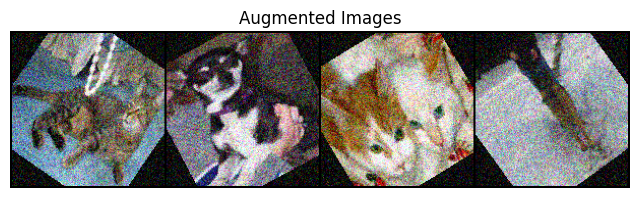


--- Training with Data Augmentation ---
Ep 1: Train L 0.6956, Acc 0.5090 | Val L 0.6908, Acc 0.5310
Ep 2: Train L 0.6912, Acc 0.5340 | Val L 0.6942, Acc 0.5000
Ep 3: Train L 0.6940, Acc 0.4975 | Val L 0.6929, Acc 0.5040
Ep 4: Train L 0.6918, Acc 0.5075 | Val L 0.7189, Acc 0.5000
Ep 5: Train L 0.6936, Acc 0.5015 | Val L 0.6932, Acc 0.5000

--- Training Baseline (No Augmentation) ---
Ep 1: Train L 0.6982, Acc 0.5110 | Val L 0.6850, Acc 0.5480
Ep 2: Train L 0.6790, Acc 0.5745 | Val L 0.6557, Acc 0.6610
Ep 3: Train L 0.6400, Acc 0.6465 | Val L 0.6138, Acc 0.6900
Ep 4: Train L 0.6112, Acc 0.6800 | Val L 0.6005, Acc 0.6830
Ep 5: Train L 0.5706, Acc 0.7105 | Val L 0.5803, Acc 0.6900

--- L2 via Weight Decay ---
Ep 1: Train L 0.6967, Acc 0.5115 | Val L 0.6888, Acc 0.5070
Ep 2: Train L 0.6871, Acc 0.5355 | Val L 0.6683, Acc 0.6160
Ep 3: Train L 0.6645, Acc 0.6055 | Val L 0.6578, Acc 0.5890
Ep 4: Train L 0.6261, Acc 0.6620 | Val L 0.6137, Acc 0.6590
Ep 5: Train L 0.6178, Acc 0.6730 | Val L 0.59

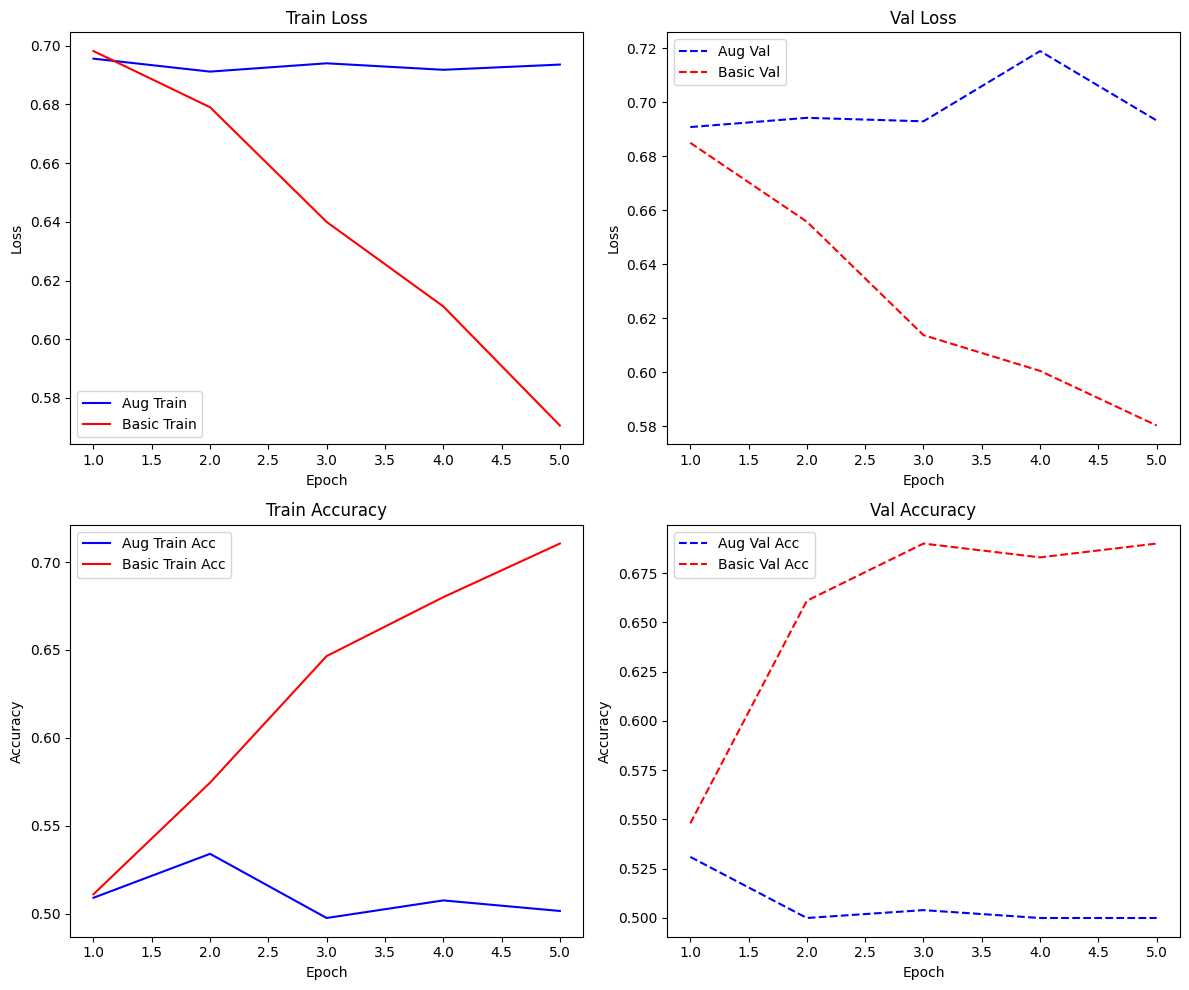

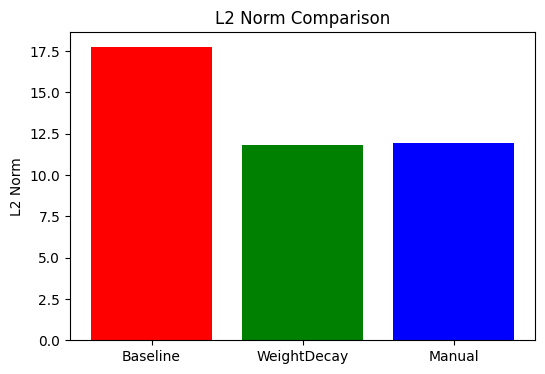

In [5]:
# --- DataLoaders ---
tr_dir = os.path.join("cats_and_dogs_filtered", "train")
vl_dir = os.path.join("cats_and_dogs_filtered", "validation")
ds_aug = MyDataset(tr_dir, transform=transform_aug)
ds_bas = MyDataset(tr_dir, transform=transform_basic)
tr_aug = DataLoader(ds_aug, batch_size=32, shuffle=True)
tr_bas = DataLoader(ds_bas, batch_size=32, shuffle=True)
ds_vl  = MyDataset(vl_dir, transform=transform_val)
vl_dl  = DataLoader(ds_vl, batch_size=32, shuffle=False)

# --- Display Augmented Images ---
it = iter(tr_aug)
imgs, _ = next(it)
grid = vutils.make_grid(imgs[:4])
plt.figure(figsize=(8,8)); plt.imshow(grid.permute(1,2,0)); plt.title("Augmented Images"); plt.axis("off"); plt.show()

# --- Model Definition ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.c = nn.Sequential(
            nn.Linear(64*18*18,128), nn.ReLU(), nn.Dropout(0.5), nn.Linear(128,2)
        )
    def forward(self,x):
        x = self.f(x)
        return self.c(x.view(x.size(0),-1))

# --- Training Loop with Optional Manual L2 ---
def train_model(m, train_dl, val_dl, crit, opt, epochs=5, l2_lambda=0.0, manual_l2=False, dev='cpu'):
    m.to(dev)
    history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
    for e in range(epochs):
        m.train(); tot=0; corr=0; ls=0
        for X,y in train_dl:
            X,y = X.to(dev), y.to(dev)
            opt.zero_grad()
            out = m(X)
            loss = crit(out,y)
            if manual_l2 and l2_lambda>0:
                reg = sum(torch.norm(p,2)**2 for p in m.parameters())
                loss += l2_lambda * reg
            loss.backward(); opt.step()
            ls += loss.item()*X.size(0)
            tot += y.size(0)
            corr += (out.argmax(1)==y).sum().item()
        epoch_loss, epoch_acc = ls/tot, corr/tot
        history['loss'].append(epoch_loss); history['acc'].append(epoch_acc)
        m.eval(); vls=0; vtot=0; vcorr=0
        with torch.no_grad():
            for X,y in val_dl:
                X,y = X.to(dev), y.to(dev)
                out = m(X)
                loss = crit(out,y)
                vls += loss.item()*X.size(0)
                vtot += y.size(0)
                vcorr += (out.argmax(1)==y).sum().item()
        val_loss, val_acc = vls/vtot, vcorr/vtot
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
        print(f"Ep {e+1}: Train L {epoch_loss:.4f}, Acc {epoch_acc:.4f} | Val L {val_loss:.4f}, Acc {val_acc:.4f}")
    return history

# --- Utility: L2 Norm ---
def compute_l2_norm(m):
    return sum(torch.norm(p,2).item()**2 for p in m.parameters())**0.5

# --- Experiments ---
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
crit = nn.CrossEntropyLoss()

# (a) Data Augmentation vs. Baseline
print("\n--- Training with Data Augmentation ---")
m_aug = SimpleCNN(); opt_aug = optim.Adam(m_aug.parameters(), lr=0.001)
hist_aug = train_model(m_aug, tr_aug, vl_dl, crit, opt_aug, epochs=5, dev=dev)

print("\n--- Training Baseline (No Augmentation) ---")
m_bas = SimpleCNN(); opt_bas = optim.Adam(m_bas.parameters(), lr=0.001)
hist_bas = train_model(m_bas, tr_bas, vl_dl, crit, opt_bas, epochs=5, dev=dev)

# (b) L2 Regularization Experiments (using non-augmented data)
print("\n--- L2 via Weight Decay ---")
m_wd = SimpleCNN(); opt_wd = optim.Adam(m_wd.parameters(), lr=0.001, weight_decay=1e-4)
hist_wd = train_model(m_wd, tr_bas, vl_dl, crit, opt_wd, epochs=5, dev=dev)

print("\n--- L2 via Manual Penalty ---")
m_man = SimpleCNN(); opt_man = optim.Adam(m_man.parameters(), lr=0.001)
hist_man = train_model(m_man, tr_bas, vl_dl, crit, opt_man, epochs=5, l2_lambda=1e-4, manual_l2=True, dev=dev)

# --- Compare L2 Norms ---
print("\nL2 Norms:")
print("Baseline:   ", compute_l2_norm(m_bas))
print("WeightDecay:", compute_l2_norm(m_wd))
print("Manual L2:  ", compute_l2_norm(m_man))

# --- Visualization ---
epochs_range = range(1,6)
plt.figure(figsize=(12,10))

# Training Loss
plt.subplot(2,2,1)
plt.plot(epochs_range, hist_aug['loss'], 'b-', label='Aug Train')
plt.plot(epochs_range, hist_bas['loss'], 'r-', label='Basic Train')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Train Loss'); plt.legend()

# Validation Loss
plt.subplot(2,2,2)
plt.plot(epochs_range, hist_aug['val_loss'], 'b--', label='Aug Val')
plt.plot(epochs_range, hist_bas['val_loss'], 'r--', label='Basic Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Val Loss'); plt.legend()

# Training Accuracy
plt.subplot(2,2,3)
plt.plot(epochs_range, hist_aug['acc'], 'b-', label='Aug Train Acc')
plt.plot(epochs_range, hist_bas['acc'], 'r-', label='Basic Train Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Train Accuracy'); plt.legend()

# Validation Accuracy
plt.subplot(2,2,4)
plt.plot(epochs_range, hist_aug['val_acc'], 'b--', label='Aug Val Acc')
plt.plot(epochs_range, hist_bas['val_acc'], 'r--', label='Basic Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Val Accuracy'); plt.legend()

plt.tight_layout()
plt.show()

# L2 Regularization Effects Visualization
plt.figure(figsize=(6,4))
methods = ['Baseline','WeightDecay','Manual']
l2_vals = [compute_l2_norm(m_bas), compute_l2_norm(m_wd), compute_l2_norm(m_man)]
plt.bar(methods, l2_vals, color=['red','green','blue'])
plt.ylabel('L2 Norm'); plt.title('L2 Norm Comparison')
plt.show()

#### 2) Implement L1 regularization on cat-dog classification neural network. Train the model on the dataset, and observe the impact of the regularization on the weight parameters. (Do not use data augmentation).
#### a. L1 regularization using optimizer’s weight decay
#### b. L1regularization using loop to find L1 norm of weights

Prox E1: Loss 0.6984, Acc 0.5200
Prox E2: Loss 0.6881, Acc 0.5470
Prox E3: Loss 0.6816, Acc 0.5640
Prox E4: Loss 0.6675, Acc 0.5955
Prox E5: Loss 0.6511, Acc 0.6310
Man E1: Loss 0.8900, Acc 0.5175
Man E2: Loss 0.7515, Acc 0.5010
Man E3: Loss 0.7410, Acc 0.5000
Man E4: Loss 0.7405, Acc 0.4860
Man E5: Loss 0.7344, Acc 0.4995

Final Results:
Proximal -> Val Acc: 0.6310, Val Loss: 0.6511, L1 Norm: 16923.4773
Manual   -> Val Acc: 0.4995, Val Loss: 0.7344, L1 Norm: 400.2690


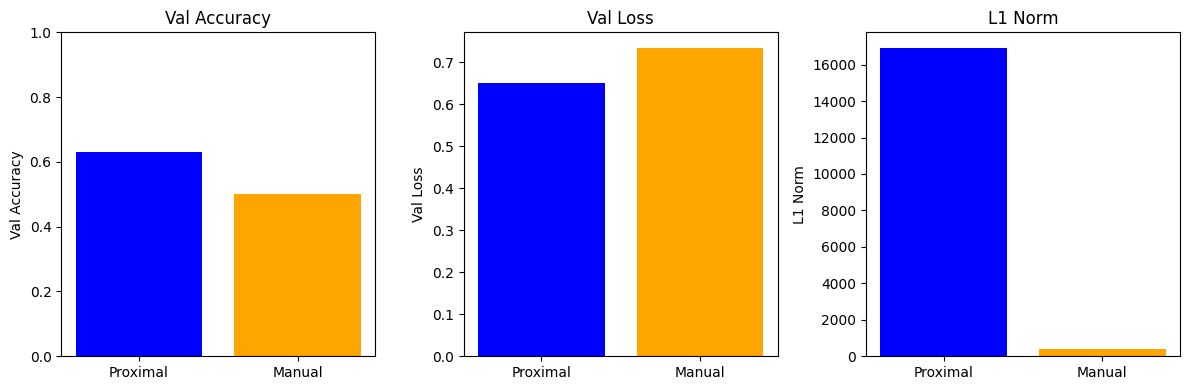

In [8]:
# Compact training function for L1 regularization with proximal update
def train_l1_prox(m, dl, vdl, crit, opt, epochs=5, l1=1e-4, dev='cpu'):
    m.to(dev)
    for e in range(epochs):
        m.train(); tot=0; corr=0; ls=0
        for X, y in dl:
            X, y = X.to(dev), y.to(dev)
            opt.zero_grad()
            out = m(X)
            loss = crit(out, y)
            loss.backward(); opt.step()
            # Proximal (soft-thresholding) update for L1
            with torch.no_grad():
                for p in m.parameters():
                    p.copy_(torch.sign(p) * torch.clamp(p.abs()-opt.param_groups[0]['lr']*l1, min=0))
            ls += loss.item()*X.size(0)
            tot += y.size(0)
            corr += (out.argmax(1)==y).sum().item()
        print(f"Prox E{e+1}: Loss {ls/tot:.4f}, Acc {corr/tot:.4f}")
    return corr/tot, ls/tot

# Compact training function for L1 regularization with manual penalty
def train_l1_man(m, dl, vdl, crit, opt, epochs=5, l1=1e-4, dev='cpu'):
    m.to(dev)
    for e in range(epochs):
        m.train(); tot=0; corr=0; ls=0
        for X, y in dl:
            X, y = X.to(dev), y.to(dev)
            opt.zero_grad()
            pen = sum(torch.sum(torch.abs(p)) for p in m.parameters())
            out = m(X)
            loss = crit(out, y) + l1*pen
            loss.backward(); opt.step()
            ls += loss.item()*X.size(0)
            tot += y.size(0)
            corr += (out.argmax(1)==y).sum().item()
        print(f"Man E{e+1}: Loss {ls/tot:.4f}, Acc {corr/tot:.4f}")
    return corr/tot, ls/tot

def l1_norm(m):
    return sum(torch.sum(torch.abs(p)).item() for p in m.parameters())

# Assume SimpleCNN is defined and train_loader_basic, val_loader, device, and criterion are available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
crit = nn.CrossEntropyLoss()

# (a) Train using proximal L1 regularization
model_prox = SimpleCNN()
opt_prox = optim.Adam(model_prox.parameters(), lr=0.001)
acc_prox, loss_prox = train_l1_prox(model_prox, tr_bas, vl_dl, crit, opt_prox, epochs=5, l1=1e-4, dev=device)

# (b) Train using manual L1 regularization
model_man = SimpleCNN()
opt_man = optim.Adam(model_man.parameters(), lr=0.001)
acc_man, loss_man = train_l1_man(model_man, tr_bas, vl_dl, crit, opt_man, epochs=5, l1=1e-4, dev=device)

norm_prox = l1_norm(model_prox)
norm_man  = l1_norm(model_man)

# Print final results
print("\nFinal Results:")
print(f"Proximal -> Val Acc: {acc_prox:.4f}, Val Loss: {loss_prox:.4f}, L1 Norm: {norm_prox:.4f}")
print(f"Manual   -> Val Acc: {acc_man:.4f}, Val Loss: {loss_man:.4f}, L1 Norm: {norm_man:.4f}")

# Visualize each metric in its own subplot
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].bar(['Proximal', 'Manual'], [acc_prox, acc_man], color=['blue', 'orange'])
axs[0].set_ylabel('Val Accuracy'); axs[0].set_ylim(0, 1); axs[0].set_title('Val Accuracy')
axs[1].bar(['Proximal', 'Manual'], [loss_prox, loss_man], color=['blue', 'orange'])
axs[1].set_ylabel('Val Loss'); axs[1].set_title('Val Loss')
axs[2].bar(['Proximal', 'Manual'], [norm_prox, norm_man], color=['blue', 'orange'])
axs[2].set_ylabel('L1 Norm'); axs[2].set_title('L1 Norm')
plt.tight_layout()
plt.show()

#### 3) Implement dropout regularization on cat-dog classification neural network. Train the model with and without dropout on a dataset, and compare the performance and overfitting tendencies.

Ep 1: TL 0.6939, TA 0.5160 | VL 0.6882, VA 0.6050
Ep 2: TL 0.6806, TA 0.5745 | VL 0.6555, VA 0.6420
Ep 3: TL 0.6692, TA 0.6090 | VL 0.6512, VA 0.6430
Ep 4: TL 0.6316, TA 0.6650 | VL 0.6040, VA 0.6820
Ep 5: TL 0.5837, TA 0.6930 | VL 0.5937, VA 0.6740
Ep 1: TL 0.6894, TA 0.5575 | VL 0.6886, VA 0.5040
Ep 2: TL 0.6775, TA 0.5500 | VL 0.6622, VA 0.6090
Ep 3: TL 0.6383, TA 0.6625 | VL 0.6304, VA 0.6440
Ep 4: TL 0.5962, TA 0.6840 | VL 0.5889, VA 0.6720
Ep 5: TL 0.5387, TA 0.7285 | VL 0.5967, VA 0.6960


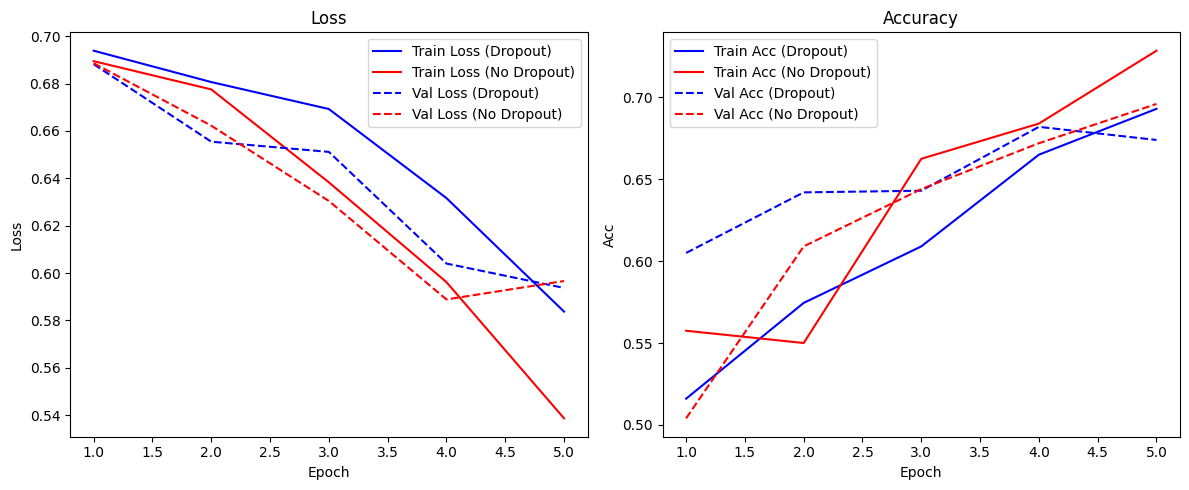

In [9]:
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt

# Model definition with dropout parameter
class CNNDrop(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.c = nn.Sequential(
            nn.Linear(64*18*18,128), nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(128,2)
        )
    def forward(self,x):
        x = self.f(x)
        return self.c(x.view(x.size(0), -1))

# Training loop that returns history
def train_hist(m, dl, vdl, crit, opt, epochs=5, dev='cpu'):
    m.to(dev)
    hist = {"tl":[], "ta":[], "vl":[], "va":[]}
    for e in range(epochs):
        m.train(); tot = 0; corr = 0; rloss = 0.0
        for X, y in dl:
            X,y = X.to(dev), y.to(dev)
            opt.zero_grad()
            out = m(X)
            loss = crit(out,y)
            loss.backward(); opt.step()
            rloss += loss.item()*X.size(0)
            tot += y.size(0)
            corr += (out.argmax(1)==y).sum().item()
        tl, ta = rloss/tot, corr/tot
        m.eval(); tot = 0; corr = 0; rloss = 0.0
        with torch.no_grad():
            for X, y in vdl:
                X,y = X.to(dev), y.to(dev)
                out = m(X)
                loss = crit(out,y)
                rloss += loss.item()*X.size(0)
                tot += y.size(0)
                corr += (out.argmax(1)==y).sum().item()
        vl, va = rloss/tot, corr/tot
        hist["tl"].append(tl); hist["ta"].append(ta)
        hist["vl"].append(vl); hist["va"].append(va)
        print(f"Ep {e+1}: TL {tl:.4f}, TA {ta:.4f} | VL {vl:.4f}, VA {va:.4f}")
    return hist

# Assume train_loader_basic, val_loader, and device are defined.
# Train model WITH dropout (p=0.5)
m1 = CNNDrop(p=0.5)
opt1 = optim.Adam(m1.parameters(), lr=0.001)
h1 = train_hist(m1, tr_bas, vl_dl, nn.CrossEntropyLoss(), opt1, epochs=5, dev=device)

# Train model WITHOUT dropout (p=0.0)
m2 = CNNDrop(p=0.0)
opt2 = optim.Adam(m2.parameters(), lr=0.001)
h2 = train_hist(m2, tr_bas, vl_dl, nn.CrossEntropyLoss(), opt2, epochs=5, dev=device)

# Plot comparison
eps = range(1,6)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(eps, h1["tl"], 'b-', label='Train Loss (Dropout)')
plt.plot(eps, h2["tl"], 'r-', label='Train Loss (No Dropout)')
plt.plot(eps, h1["vl"], 'b--', label='Val Loss (Dropout)')
plt.plot(eps, h2["vl"], 'r--', label='Val Loss (No Dropout)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(eps, h1["ta"], 'b-', label='Train Acc (Dropout)')
plt.plot(eps, h2["ta"], 'r-', label='Train Acc (No Dropout)')
plt.plot(eps, h1["va"], 'b--', label='Val Acc (Dropout)')
plt.plot(eps, h2["va"], 'r--', label='Val Acc (No Dropout)')
plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.title('Accuracy'); plt.legend()
plt.tight_layout(); plt.show()

#### 4) Implement your own version of the dropout layer by using Bernoulli distribution and compare the performance with the library.

Library Dropout: Val Acc = 0.5 Val Loss = 0.6933509469032287
Custom Dropout:  Val Acc = 0.5 Val Loss = 0.6955169987678528


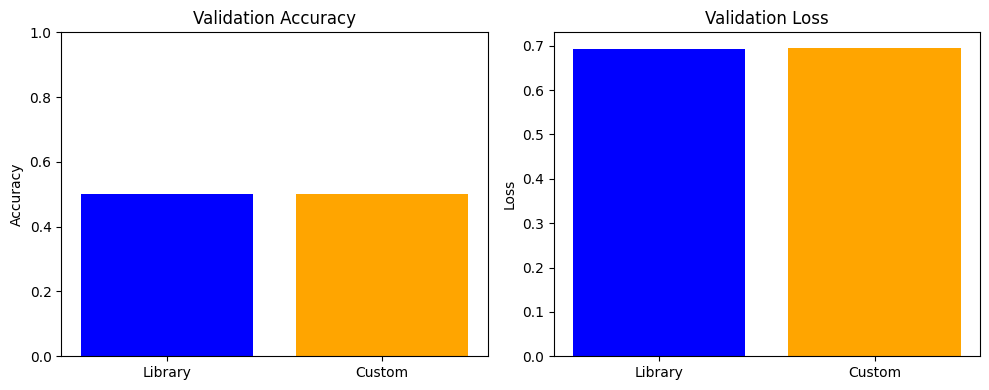

In [12]:
# Custom Dropout using Bernoulli
class MyDropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p
    def forward(self, x):
        if not self.training or self.p == 0:
            return x
        mask = torch.bernoulli(torch.full_like(x, 1 - self.p))
        return x * mask / (1 - self.p)

# CNN with library dropout
class SimpleCNNLib(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*18*18,128), nn.ReLU(), nn.Dropout(p), nn.Linear(128,2)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x.view(x.size(0), -1))

# CNN with custom dropout
class SimpleCNNCustom(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*18*18,128), nn.ReLU(), MyDropout(p), nn.Linear(128,2)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x.view(x.size(0), -1))

# Minimal training loop that returns final validation accuracy and loss
def train_model_dropout(model, train_loader, val_loader, criterion, optimizer, epochs=5, dev='cpu'):
    model.to(dev)
    for _ in range(epochs):
        model.train()
        for X, y in train_loader:
            X, y = X.to(dev), y.to(dev)
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            optimizer.step()
    model.eval()
    tot = corr = vloss = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(dev), y.to(dev)
            out = model(X)
            loss = criterion(out, y)
            vloss += loss.item() * y.size(0)
            tot += y.size(0)
            corr += (out.argmax(1) == y).sum().item()
    return corr / tot, vloss / tot

# Assume train_loader_basic, val_loader, criterion, and device are defined
acc_lib, loss_lib = train_model_dropout(SimpleCNNLib(0.5), tr_bas, vl_dl, crit, optim.Adam(SimpleCNNLib(0.5).parameters(), lr=0.001), epochs=5, dev=device)
acc_custom, loss_custom = train_model_dropout(SimpleCNNCustom(0.5), tr_bas, vl_dl, crit, optim.Adam(SimpleCNNCustom(0.5).parameters(), lr=0.001), epochs=5, dev=device)

print("Library Dropout: Val Acc =", acc_lib, "Val Loss =", loss_lib)
print("Custom Dropout:  Val Acc =", acc_custom, "Val Loss =", loss_custom)

# Visualize results
methods = ['Library', 'Custom']
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(methods, [acc_lib, acc_custom], color=['blue','orange'])
plt.ylabel('Accuracy'); plt.title('Validation Accuracy'); plt.ylim(0,1)
plt.subplot(1,2,2)
plt.bar(methods, [loss_lib, loss_custom], color=['blue','orange'])
plt.ylabel('Loss'); plt.title('Validation Loss')
plt.tight_layout()
plt.show()

#### 5) Implement early stopping as a form of regularization. Train a neural network and monitor the validation loss. Stop training when the validation loss starts increasing, and compare the performance with a model trained without early stopping.


Training with Early Stopping:
ES Epoch 1: Val Loss = 0.6889
ES Epoch 2: Val Loss = 0.6726
ES Epoch 3: Val Loss = 0.6643
ES Epoch 4: Val Loss = 0.6113
ES Epoch 5: Val Loss = 0.5913
ES Epoch 6: Val Loss = 0.5941
ES Epoch 7: Val Loss = 0.6007
ES Epoch 8: Val Loss = 0.5719
ES Epoch 9: Val Loss = 0.5982
ES Epoch 10: Val Loss = 0.6114
ES Epoch 11: Val Loss = 0.7002
ES Epoch 12: Val Loss = 0.8224
ES Epoch 13: Val Loss = 1.0146
ES Epoch 14: Val Loss = 1.0900
Early stopping at epoch 14 (no improvement for 5 epochs).

Training without Early Stopping:
Fixed Epoch 1: Val Loss = 0.6916
Fixed Epoch 2: Val Loss = 0.6872
Fixed Epoch 3: Val Loss = 0.6449
Fixed Epoch 4: Val Loss = 0.6453
Fixed Epoch 5: Val Loss = 0.6626
Fixed Epoch 6: Val Loss = 0.6202
Fixed Epoch 7: Val Loss = 0.6367
Fixed Epoch 8: Val Loss = 0.7178
Fixed Epoch 9: Val Loss = 0.8259
Fixed Epoch 10: Val Loss = 0.8914
Fixed Epoch 11: Val Loss = 1.2297
Fixed Epoch 12: Val Loss = 1.6129
Fixed Epoch 13: Val Loss = 1.6872
Fixed Epoch 14: Val

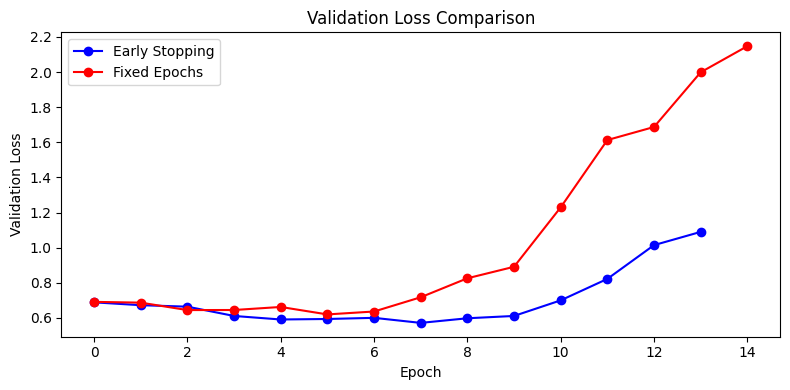

In [15]:
# Define a simple CNN model (YourModel)
class YourModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*18*18,128), nn.ReLU(), nn.Linear(128,2)
        )
    def forward(self, x):
        x = self.conv(x)
        return self.fc(x.view(x.size(0), -1))

# Early stopping training loop
def train_es(model, train_dl, val_dl, crit, opt, max_epochs, patience, dev):
    model.to(dev)
    best_loss = float('inf')
    wait = 0
    es_losses = []
    best_state = None
    for ep in range(max_epochs):
        model.train()
        for X, y in train_dl:
            X, y = X.to(dev), y.to(dev)
            opt.zero_grad()
            loss = crit(model(X), y)
            loss.backward(); opt.step()
        model.eval()
        tot, loss_sum = 0, 0
        with torch.no_grad():
            for X, y in val_dl:
                X, y = X.to(dev), y.to(dev)
                loss = crit(model(X), y)
                loss_sum += loss.item()*y.size(0)
                tot += y.size(0)
        curr_loss = loss_sum/tot
        es_losses.append(curr_loss)
        print(f"ES Epoch {ep+1}: Val Loss = {curr_loss:.4f}")
        if curr_loss < best_loss:
            best_loss = curr_loss; wait = 0; best_state = model.state_dict()
        else:
            wait += 1
        if wait > patience:
            print(f"Early stopping at epoch {ep+1} (no improvement for {patience} epochs).")
            break
    model.load_state_dict(best_state)
    return model, best_loss, es_losses

# Fixed epochs training loop
def train_fixed(model, train_dl, val_dl, crit, opt, epochs, dev):
    model.to(dev)
    fix_losses = []
    for ep in range(epochs):
        model.train()
        for X, y in train_dl:
            X, y = X.to(dev), y.to(dev)
            opt.zero_grad()
            loss = crit(model(X), y)
            loss.backward(); opt.step()
        model.eval()
        tot, loss_sum = 0, 0
        with torch.no_grad():
            for X, y in val_dl:
                X, y = X.to(dev), y.to(dev)
                loss = crit(model(X), y)
                loss_sum += loss.item()*y.size(0)
                tot += y.size(0)
        curr_loss = loss_sum/tot
        fix_losses.append(curr_loss)
        print(f"Fixed Epoch {ep+1}: Val Loss = {curr_loss:.4f}")
    return model, fix_losses[-1], fix_losses

# Use your non-augmented training and validation loaders:
# tr_bas (training) and vl_dl (validation) are defined in previous cells.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

# Train with early stopping
print("\nTraining with Early Stopping:")
model_es = YourModel()
opt_es = optim.Adam(model_es.parameters(), lr=0.001)
model_es, best_es_loss, es_losses = train_es(model_es, tr_bas, vl_dl, criterion, opt_es, max_epochs=50, patience=5, dev=device)

# Train without early stopping (fixed 50 epochs)
print("\nTraining without Early Stopping:")
model_fix = YourModel()
opt_fix = optim.Adam(model_fix.parameters(), lr=0.001)
model_fix, final_fix_loss, fix_losses = train_fixed(model_fix, tr_bas, vl_dl, criterion, opt_fix, epochs=15, dev=device)

print("\nFinal Results:")
print("Early Stopping Best Val Loss:", best_es_loss)
print("Fixed Epochs Final Val Loss:", final_fix_loss)

# Visualize validation loss curves
plt.figure(figsize=(8,4))
plt.plot(es_losses, 'b-o', label='Early Stopping')
plt.plot(fix_losses, 'r-o', label='Fixed Epochs')
plt.xlabel('Epoch'); plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend(); plt.tight_layout()
plt.show()